### BNC Challenge 2008 課題の前後でのチャンネル同士のコネクティビティの変化
[Development of Global Cortical Networks in Early Infancy](http://www.jneurosci.org/content/30/14/4877)を参考に

検定の流れは
+ １人の被験者につき代表値を462(22ch×21ch)個（タスク別に）算出
+ 横軸に事前事後、縦軸にzスコアをとり９人それぞれの点をプロット
+ この図についてt検定
+ p値ではなくFDRを考慮したq値で優位差を判断

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.signal import correlate
from scipy.stats import zscore, norm, ttest_rel
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(style="whitegrid", color_codes=True)
import mne

In [2]:
event_id = dict(left_hand=1, right_hand=2, feet=3, tongue=4)  # event ID

In [3]:
fs = 250 # Sampling frequency
info = mne.create_info(["ch"+str(i) for i in range(25)], fs) #  Channel labels and sampling freq.

In [4]:
# Read events from csv
subjects = ['A01T', 'A02T', 'A03T', 'A04T', 'A05T', 'A06T', 'A07T', 'A08T', 'A09T']
#subjects = ['A01T', 'A02T', 'A03T']
#events = [0] * len(subjects)
#eegs = [0] * len(subjects)
#raw = [0] * len(subjects)
epochs = [0] * len(subjects)
cm_post = [0] * len(subjects)
#cm_binary = [0] * len(subjects)
#one_cm = [0] * len(subjects)
cm_pre = [0] * len(subjects)
#cm_pre_binary = [0] * len(subjects)

In [5]:
for (i, subject) in enumerate(subjects):
    events = pd.read_csv('./datasets/events_'+subject+'.csv', header=None)
    events = np.array(events.astype(int))
    eegs = pd.read_csv('./datasets/eeg_'+subject+'.csv', header=None)
    raw = mne.io.array.RawArray(eegs, info)
    epochs[i] = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=6.0, baseline=(None,0), preload=True, add_eeg_ref=False)

Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading data for 336 events and 1501 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=25, n_times=677145
    Range : 0 ... 677144 =      0.000 ...  2708.576 secs
Ready.
336 matching events found
0 projection items activated
Loading

In [6]:
def calc_mean_coef_z(epochs, event, pre, ch1, ch2):
    if(pre):
        signal = epochs[event].get_data()[:,[ch1,ch2],0:500]
    else:
        signal = epochs[event].get_data()[:,[ch1,ch2],750:1250]
    trial_num = signal.shape[0]
    coefs = [max(correlate(signal[trial,0,:], signal[trial,1,:])) / (np.linalg.norm(signal[trial,0,:])*np.linalg.norm(signal[trial,1,:])) for trial in range(trial_num)]
    mean_r = np.array(coefs).mean()
    # Fisher's z transformation
    z_score = np.arctanh(mean_r)
    return z_score

In [67]:
def make_comparable_data(epochs, event, ch1, ch2):
    data = {"pre":[], "post":[]}
    for i in range(len(epochs)):
        data["pre"].append(calc_mean_coef_z(epochs[i], event, True, ch1, ch2))
        data["post"].append(calc_mean_coef_z(epochs[i], event, False, ch1, ch2))
        title = "ch{0}-ch{1}".format(ch1, ch2)
    df = pd.DataFrame(data)
    return df, event, title

In [89]:
def df2sns(df):
    data = {"z_score":[], "condition":[]}
    for ix, row in df.iterrows():
        data['z_score'].append(row.pre)
        data['z_score'].append(row.post)
        data['condition'].append('pre')
        data['condition'].append('post')
    return pd.DataFrame(data)

In [73]:
def srs2sns(series):
    data = {"z_score":[], "condition":['pre', 'post']}
    data['z_score'].append(series.pre)
    data['z_score'].append(series.post)
    return pd.DataFrame(data)

例えば、左手条件でのch10-ch11間の相関係数の差を９人で検定することを考える

In [68]:
df, eventname, title = make_comparable_data(epochs, "left_hand", 10,11)
df

,post,pre
0,1.900219,1.949368
1,1.886598,1.984965
2,1.888672,2.055477
3,1.778253,1.896666
4,1.899932,1.987831
5,1.652200,1.666789
6,1.753118,1.812420
7,1.995258,1.845287
8,1.790768,1.572416


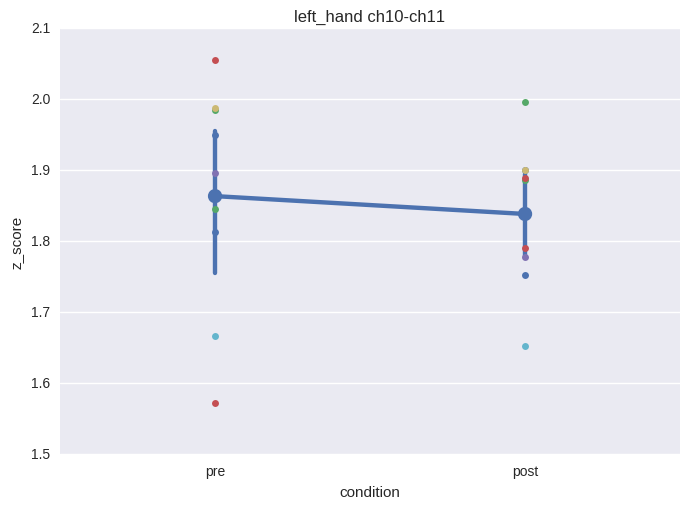

In [91]:
ax = sns.pointplot("condition", y="z_score", data=df2sns(df))
palette = sns.color_palette(n_colors=len(df))
for i in range(len(df)):
    data = srs2sns(df.ix[i])
    sns.stripplot(x="condition", y="z_score", data=data, color=palette[i])
ax.set_title(eventname+" "+title)

In [88]:
t, p = ttest_rel(df.pre, df.post)
print("p = {0}".format(p))

p = 0.5703448688414655


結果はpreとpostの間に有意な差があるとは結論付けられなかった

この要領で４条件×（２２ｃｈ×２１ｃｈ）の組み合わせを全通り検定する

In [94]:
def test_corr(epochs, event, ch1, ch2):
    df, eventname, title = make_comparable_data(epochs, event, ch1, ch2)
    t, p = ttest_rel(df.pre, df.post)
    return p

In [95]:
results = {}
ch_num = 22
for event in event_id.keys():
    for ch1 in range(ch_num):
        for ch2 in range(ch_num):
            if ch1 >= ch2:
                continue
            p = test_corr(epochs, event, ch1, ch2)
            results["{0}_ch{1}-ch{2}".format(event, ch1, ch2)] = p

In [96]:
# False Discovery Rateを考慮した検定
reject, pvals,_,_ = multipletests(list(results.values()))

In [97]:
for i, (k, v) in enumerate(results.items()):
    if(reject[i]):
        print("{0} p={1}".format(k, v))

tongue_ch6-ch13 p=3.5771950237085395e-05
tongue_ch4-ch9 p=4.614584283418151e-05
tongue_ch3-ch8 p=1.4562838063543326e-06
tongue_ch5-ch8 p=6.601919840183691e-06
tongue_ch4-ch8 p=2.050111049352579e-06
tongue_ch9-ch10 p=1.3818106689473088e-05
tongue_ch8-ch10 p=2.7335755895412576e-05
tongue_ch5-ch7 p=5.362006354830689e-05
tongue_ch3-ch10 p=2.8846136843314706e-05


In [105]:
def plot_corr(epochs, event, ch1, ch2):
    df, eventname, title = make_comparable_data(epochs, event, ch1, ch2)
    ax = sns.pointplot("condition", y="z_score", data=df2sns(df))
    palette = sns.color_palette("Set1", n_colors=len(df))
    for i in range(len(df)):
        data = srs2sns(df.ix[i])
        sns.stripplot(x="condition", y="z_score", data=data, color=palette[i])
    ax.set_title(eventname+" "+title)

有意差がでたチャンネルの組み合わせ

図を見ると信頼区間が重なっていますが、それでも有意差が出るときはあるようです

参考 [http://id.fnshr.info/2014/12/17/stats-done-wrong-06/](http://id.fnshr.info/2014/12/17/stats-done-wrong-06/)

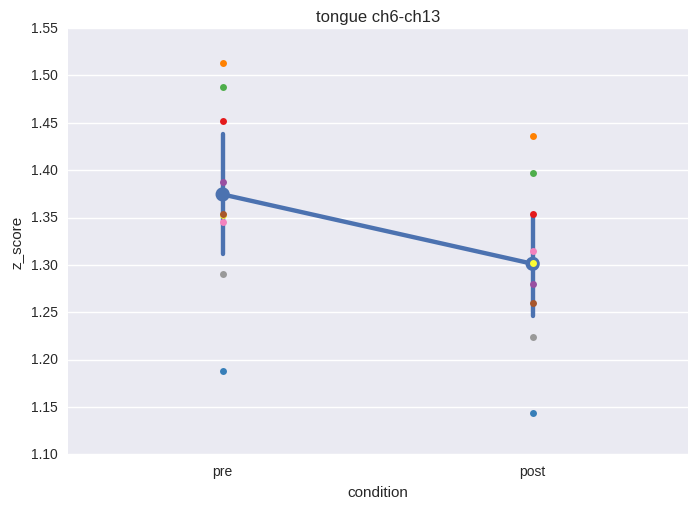

In [106]:
plot_corr(epochs, "tongue", 6, 13)

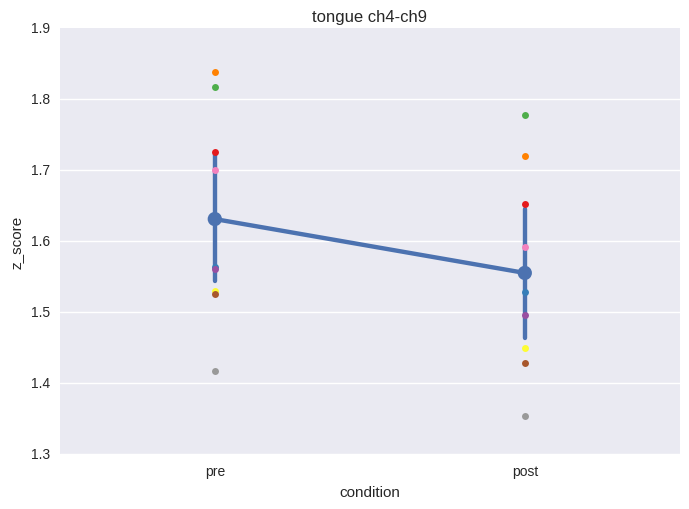

In [107]:
plot_corr(epochs, "tongue", 4, 9)

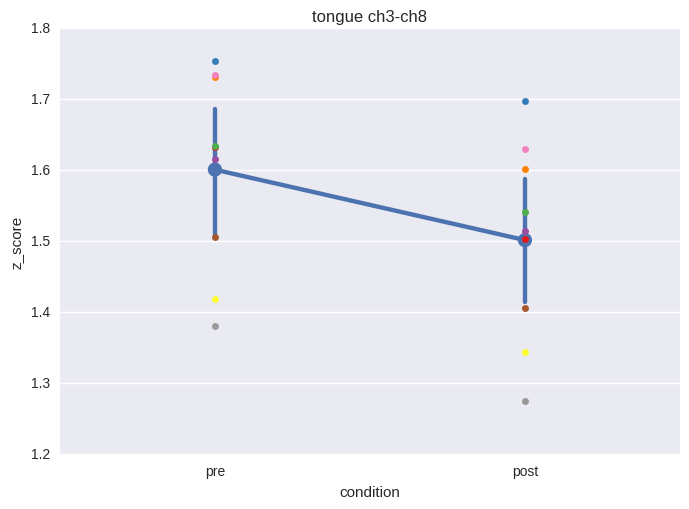

In [108]:
plot_corr(epochs, "tongue", 3, 8)

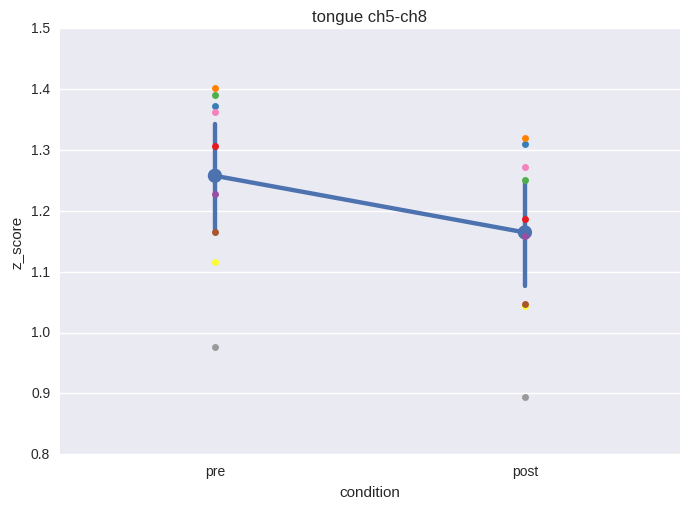

In [109]:
plot_corr(epochs, "tongue", 5, 8)

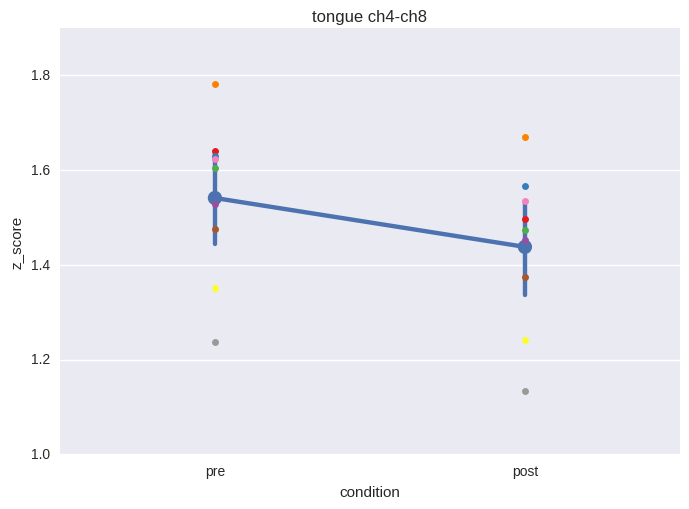

In [110]:
plot_corr(epochs, "tongue", 4, 8)

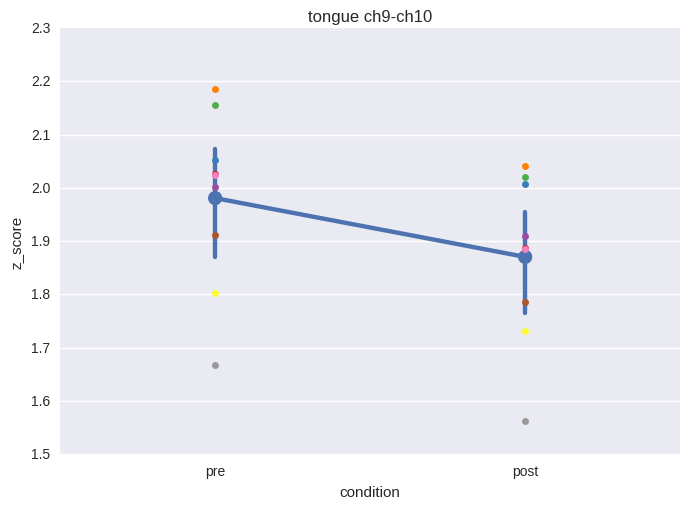

In [111]:
plot_corr(epochs, "tongue", 9, 10)

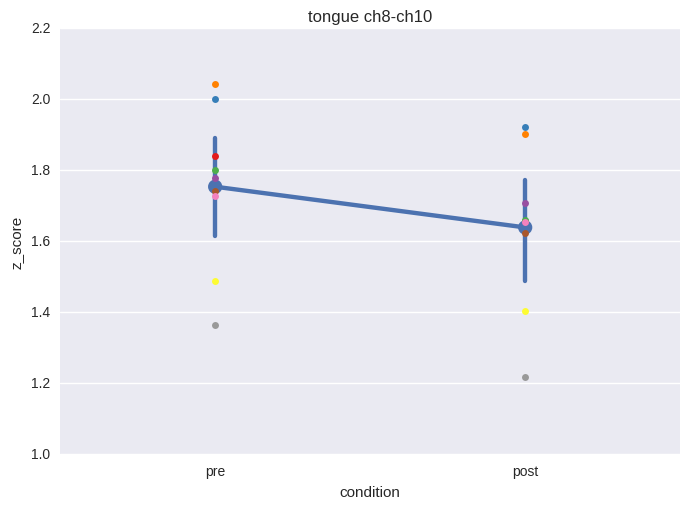

In [112]:
plot_corr(epochs, "tongue", 8, 10)

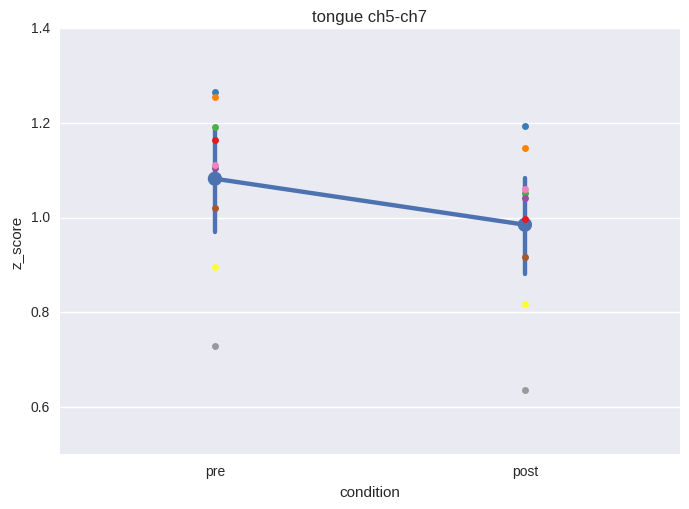

In [113]:
plot_corr(epochs, "tongue", 5, 7)

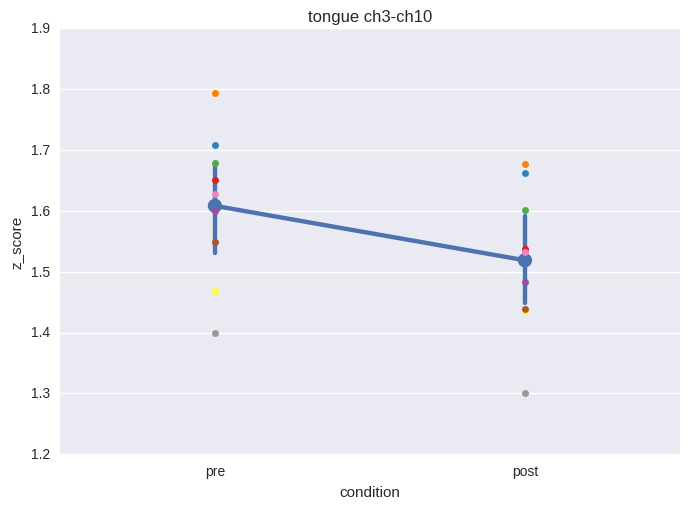

In [114]:
plot_corr(epochs, "tongue", 3, 10)